In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
r = 0.02            # risk free rate
sigma = 0.15        # volatility
x0 = 1.0            # initial stock price 
T = 6               # months
N = 50              # number of simulations or paths
n = 10 * 6          # number of steps
K = 1.1             # Exercise price

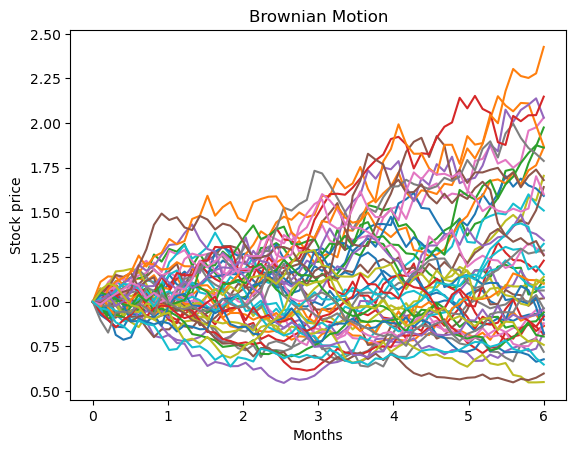

In [3]:
### Brownian Motion Paths
# time step
dt = T / n

# Set up St for each step
St = np.exp((r - np.square(sigma) / 2) * dt + sigma * np.random.normal(0, np.sqrt(dt), size=(n - 1, N)))
# First value starts at 1
St = np.vstack([np.ones(N), St])
# Calculate each step value
paths = x0 * St.cumprod(axis=0)

### Graph result
time = np.linspace(0, T, n)

# Plot results
plt.plot(time, paths)
plt.xlabel("Months")
plt.ylabel("Stock price")
plt.title("Brownian Motion");

In [4]:
time.shape, paths.shape

((60,), (60, 50))

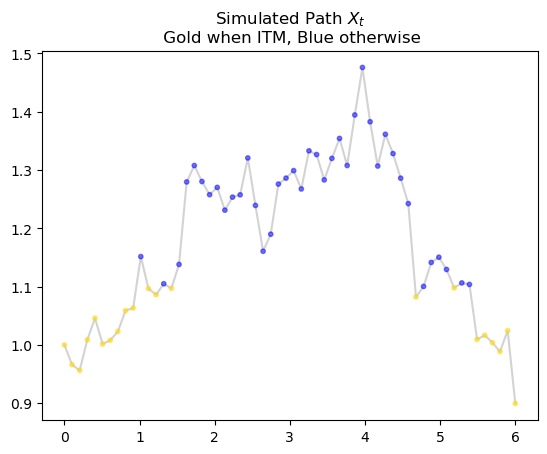

In [5]:
colors = ['gold' if (x<K) else 'blue' for x in paths[:, 20]]
plt.plot(time, paths[:, 20], color="lightgray")
plt.scatter(time, paths[:, 20], c=colors, s=10, zorder=3, alpha=0.5)
plt.title("Simulated Path $X_t$\n Gold when ITM, Blue otherwise")
plt.show()


- A every time $t_{i}$, the holder can exercise the option to obtain the payoff, i.e.:

$$\hbox{Exercise Value} = Y(t_{i}) = (K -X(t_{i}))^+.$$

- We want to estimate the Continuation Value,

$$ \hbox{Continuation Value} = C(t_{i})$$

## Longstaff-Schwartz Algorithm


- This is a backwards algorithm, so we will start at time $T=t_n$. 

- At time $t_n$, the option value is exactly the payoff as there is no more time left.

$$U(t_n) = Y(t_n) = (K -X(t_{n}))^+.$$


- A time $t_{n-1}$,  we want to find what is the best choice between Exercise and Continuation, i.e.:

$$U(t_{n-1}) = \max\left\{  Y(t_{n-1}),  C(t_{n-1})\right\},$$

where 

$$C(t_{n-1}) = D(t_n, t_{n-1}) \mathbb{E}[U(t_n) \mid \mathcal{F}_{n-1}]$$
The value of exercise is 

$$\hbox{Exercise Value} = Y(t_{n-1}) = (K -X(t_{n-1}))^+.$$


Now the key observation is that **if** the holder decides not to exercise, then our option behaves like an European one (the exercise decision has to be made in the next step and there is no early exit choice) over the period $[t_{n-1}, t_n]$. Thus, we know the discounted value of the option would be given by

$$ \hbox{Discounted Cashflow} = V(t_{n-1}, t_n) = e^{-r(t_n - t_{n-1})}( K - X(t_n))^+.$$

In [6]:
def exercise_value(x):
    return np.maximum(K - x, 0)

In [7]:
X = paths
X.shape

(60, 50)

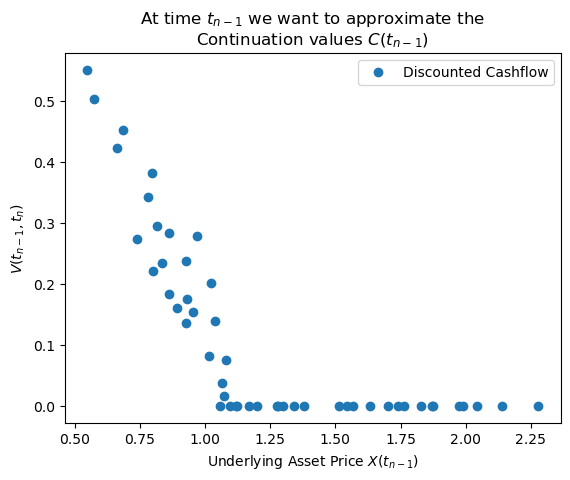

In [8]:
cashflow = exercise_value(X[-1, :]) * np.exp(-r * (time[-2] - time[-1]))
x = X[-2, :]
plt.figure()
plt.plot(x, cashflow, "o", label="Discounted Cashflow")
plt.ylabel("$V(t_{n-1},t_n)$")
plt.xlabel("Underlying Asset Price $X(t_{n-1})$")
plt.title("At time $t_{n-1}$ we want to approximate the\nContinuation values $C(t_{n-1})$")
plt.legend()
plt.show()

The idea of the Longstaff-Schwartz Algorithm is to use the least-squares method to fit a polynomial function to the pairs
\begin{equation*}
			(X(t_{n-1}, \omega), V(t_{n-1}, t_{n}, \omega)),
\end{equation*}
and then use such polynomial to approximate the continuation value as follows:
\begin{equation}
		   C(t_{n-1}) \approx \sum_{j=0}^{\infty} \hat{\alpha}_{ij} L_{j}(X(t_i)).
\end{equation}

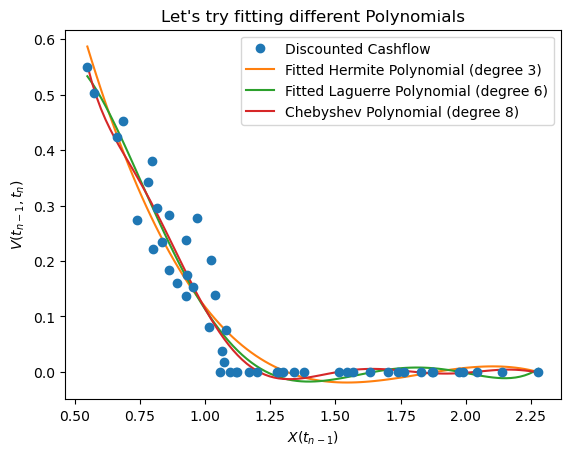

In [9]:
cashflow = exercise_value(X[-1, :]) * np.exp(-r * (time[-2] - time[-1]))
x = X[-2, :]
plt.figure()
plt.plot(x, cashflow, "o", label="Discounted Cashflow", zorder=3)
fitted = np.polynomial.Hermite.fit(x, cashflow, 3)
fitted_laguerre = np.polynomial.Laguerre.fit(x, cashflow, 6)
fitted_chebyshev = np.polynomial.Chebyshev.fit(x, cashflow, 8)
plt.plot(*fitted.linspace(), label="Fitted Hermite Polynomial (degree 3)")
plt.plot(*fitted_laguerre.linspace(), label="Fitted Laguerre Polynomial (degree 6)")
plt.plot(*fitted_chebyshev.linspace(), label="Chebyshev Polynomial (degree 8)")
plt.xlabel("$X(t_{n-1})$")
plt.ylabel("$V(t_{n-1}, t_n)$")
plt.legend()
plt.title("Let's try fitting different Polynomials")
plt.show()

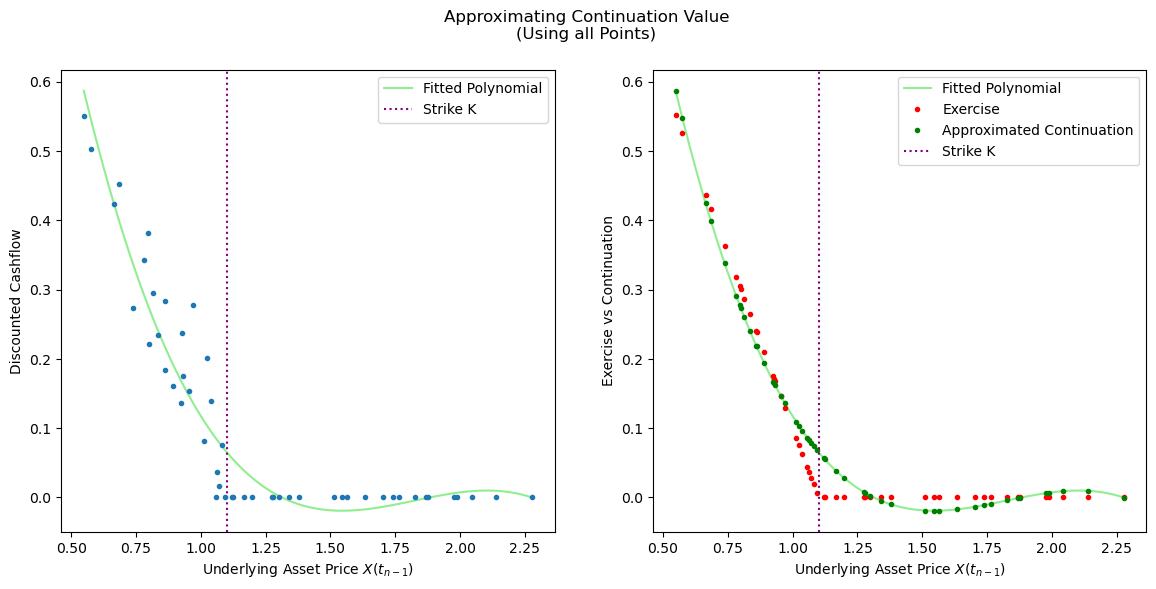

Polynomial([-0.01370838, -0.0782993 ,  0.3069772 , -0.21534885], domain=[0.54853064, 2.27842879], window=[-1.,  1.], symbol='x')

In [10]:
cashflow = exercise_value(X[-1, :]) * np.exp(-r * (time[-2] - time[-1]))
x = X[-2, :]
exercise = exercise_value(x)
fitted = np.polynomial.Polynomial.fit(x, cashflow, 3)
continuation = fitted(x)

fig, axs = plt.subplots(1, 2, figsize=(14,6))
axs[0].plot(x, cashflow, ".", zorder=3)
axs[0].plot(*fitted.linspace(),  color="lightgreen", label="Fitted Polynomial")
axs[0].axvline(x=1.1, linestyle=":", color="purple", label="Strike K")

axs[1].plot(*fitted.linspace(),  color="lightgreen", label="Fitted Polynomial")
axs[1].plot(x, exercise, '.', color="red", label="Exercise")
axs[1].plot(x, continuation, '.', color="green", label= "Approximated Continuation")
axs[1].axvline(x=1.1, linestyle=":", color="purple", label="Strike K")
axs[0].set_xlabel("Underlying Asset Price $X(t_{n-1})$")
axs[0].set_ylabel("Discounted Cashflow")
axs[1].set_xlabel("Underlying Asset Price $X(t_{n-1})$")
axs[1].set_ylabel("Exercise vs Continuation")
axs[0].legend()
axs[1].legend()
plt.suptitle("Approximating Continuation Value\n(Using all Points)")
plt.show()
fitted

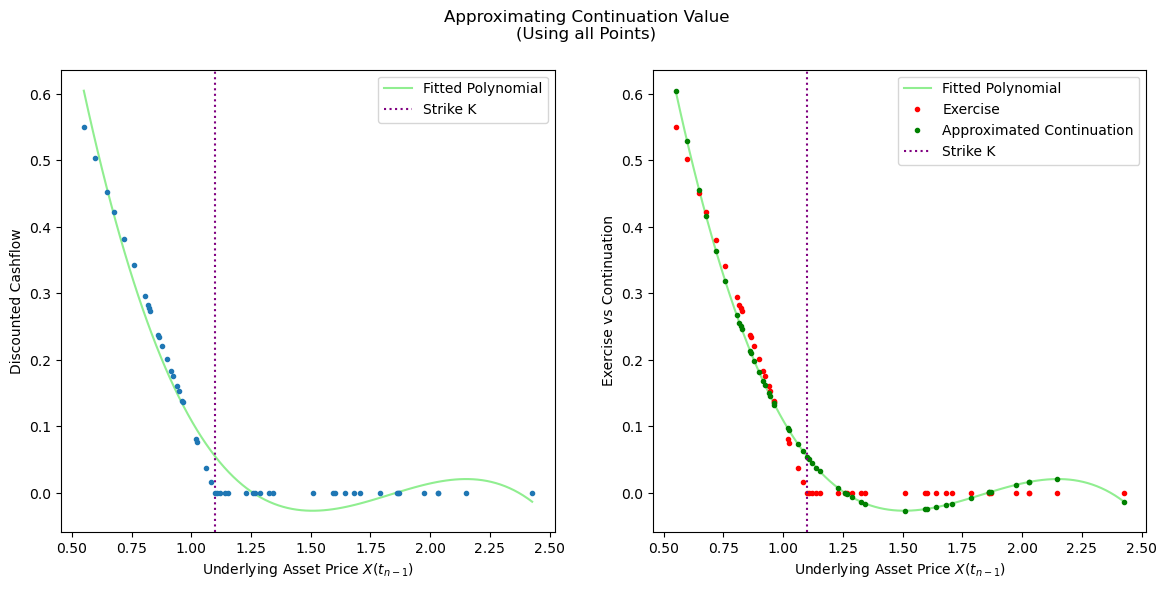

Polynomial([-0.02689744, -0.0126023 ,  0.32255464, -0.29651181], domain=[0.55040637, 2.42659998], window=[-1.,  1.], symbol='x')

In [11]:
cashflow = exercise_value(X[-1, :]) * np.exp(-r * (time[-2] - time[-1]))
x = X[-1, :]
exercise = exercise_value(x)
fitted = np.polynomial.Polynomial.fit(x, cashflow, 3)
continuation = fitted(x)

fig, axs = plt.subplots(1, 2, figsize=(14,6))
axs[0].plot(x, cashflow, ".", zorder=3)
axs[0].plot(*fitted.linspace(),  color="lightgreen", label="Fitted Polynomial")
axs[0].axvline(x=1.1, linestyle=":", color="purple", label="Strike K")

axs[1].plot(*fitted.linspace(),  color="lightgreen", label="Fitted Polynomial")
axs[1].plot(x, exercise, '.', color="red", label="Exercise")
axs[1].plot(x, continuation, '.', color="green", label= "Approximated Continuation")
axs[1].axvline(x=1.1, linestyle=":", color="purple", label="Strike K")
axs[0].set_xlabel("Underlying Asset Price $X(t_{n-1})$")
axs[0].set_ylabel("Discounted Cashflow")
axs[1].set_xlabel("Underlying Asset Price $X(t_{n-1})$")
axs[1].set_ylabel("Exercise vs Continuation")
axs[0].legend()
axs[1].legend()
plt.suptitle("Approximating Continuation Value\n(Using all Points)")
plt.show()
fitted

In [25]:
intermediate_results = []
cashflow = exercise_value(X[-1, :])

# Iterating Backwards in Time
for i in reversed(range(1, X.shape[0] - 1)):
    # Discount Factor Between t[i] and t[i+1] (always the same since grid is equidistant)
    df = np.exp(-r * (time[i + 1] - time[i]))
    # Discounted cashflows from next period
    cashflow = cashflow * df
    # Price of the stock at current period
    x = X[i, :]
    # Exercise value at time t[i]
    exercise = exercise_value(x)
    # Index for In-the-Money paths
    itm = exercise_value(x) > 0
    # Fit polynomial to estimate Continuation Value at time t[i]
    fitted = np.polynomial.Polynomial.fit(x[itm], cashflow[itm], 3)
    # Estimate Continuation Value at time t[i]
    continuation = fitted(x)
    # Index where Exercise is Beneficial
    ex_idx = itm & (exercise > continuation)
    # Update cashflows with early exercises
    cashflow[ex_idx] = exercise[ex_idx]
    
    intermediate_results.append(
        (cashflow, x, fitted, continuation, exercise, ex_idx))

In [13]:
def plot_approx_n(n_steps, ax):
    cashflow, x, fitted, continuation, exercise, ex_idx = intermediate_results[n_steps]
    fitted_x, fitted_y = fitted.linspace()
    ax.axvline(x=1.1, linestyle=":", color="purple", label="$K$")
    ax.plot(x[ex_idx], exercise[ex_idx], ".", color="red", zorder=5, label="Favourable Exercise")
    ax.plot(x[~ex_idx], exercise[~ex_idx], ".", color="green", zorder=4, label="Unfavourable Exercise")
    ax.plot(fitted_x, fitted_y, zorder=2,color="lightgreen", label="Approximated Continuation Value")
    _x = np.linspace(np.min(x), np.max(x))
    ax.plot(_x, fitted(_x), "--", color="lightgrey", zorder=1)
    ax.legend()

In [ ]:
indices = [10, 20]
t = time
for n, i in enumerate(indices):
    fig, ax = plt.subplots()
    plot_approx_n(i, ax)
    ax.set_title(f"Approximation of Continuation Value at t={t[-i-1]:0.2f}")
    plt.xlabel("Underlying Asset Price X(t)")
    plt.ylabel("Exercise / Continuation Value")
    plt.show()

In [26]:
exercise_times = []
exercises = []
non_exercise_times = []
non_exercises = []
for i, (cashflow, x, fitted, continuation, exercise, ex_idx) in enumerate(intermediate_results):
    for ex in x[ex_idx]:
        exercise_times.append(t[-i - 1])
        exercises.append(ex)
    for ex in x[~ex_idx]:
        non_exercise_times.append(t[-i - 1])
        non_exercises.append(ex)

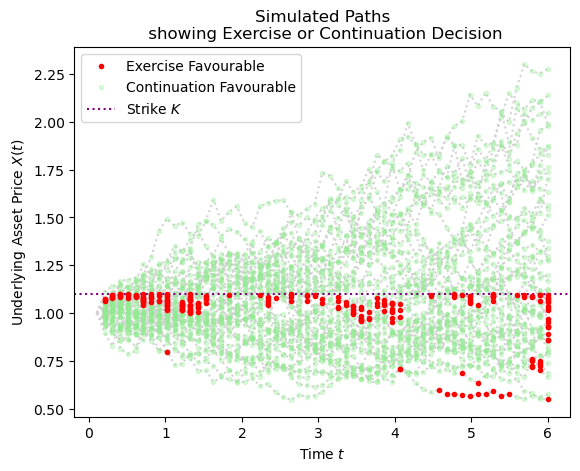

In [27]:
plt.figure()
for path in paths.T:
    plt.plot(time[1:], path[:-1], ':', color="lightgrey", zorder=1)
plt.plot(exercise_times, exercises, ".", color="red", label="Exercise Favourable", zorder=3)
plt.plot(non_exercise_times, non_exercises, ".", color="lightgreen", alpha=0.3, label="Continuation Favourable")
plt.axhline(y=1.1, linestyle=':', color="purple", label="Strike $K$")
plt.legend()
plt.xlabel("Time $t$")
plt.ylabel("Underlying Asset Price $X(t)$")
plt.title("Simulated Paths\n showing Exercise or Continuation Decision")
plt.show()

In [17]:
df = np.exp(-r * (t[1] - t[0]))
american_option = cashflow * df
european_option = exercise_value(X[-1, :]) * df

In [18]:
assert np.average(american_option) >= np.average(european_option)
print(np.round(np.average(american_option), 4))
print(np.round(np.average(european_option), 4))

0.1691
0.1162
